In [1]:
!pip install qiskit
!pip install qiskit_experiments
!pip install azure-quantum[qiskit]==0.23.201228b1

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:

from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider (
    resource_id = "/subscriptions/33e6f75e-0499-425c-8b7d-9f593dde82b6/resourceGroups/AQET/providers/Microsoft.Quantum/Workspaces/CHEM560",
    location = "westus")


from IPython.display import Image
from IPython.core.display import HTML 

import qiskit

from qiskit_experiments.framework import ParallelExperiment
import qiskit.quantum_info as qi
from qiskit_experiments.library import StateTomography

from qiskit import QuantumCircuit, assemble, Aer
from math import pi, sqrt
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city





In [3]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

print("This workspace's targets:")
for backend in provider.backends():
    print("- " + backend.name())

This workspace's targets:
- ionq.qpu
- ionq.simulator
- quantinuum.hqs-lt-s1
- quantinuum.hqs-lt-s1-apival
- quantinuum.hqs-lt-s2
- quantinuum.hqs-lt-s2-apival
- quantinuum.hqs-lt-s1-sim


In [4]:
ionq_simulator_backend = provider.get_backend("ionq.simulator")
ionq_qpu_backend = provider.get_backend("ionq.qpu")
aer_simulator_backend = Aer.get_backend('aer_simulator')

# CHEM 560 Problem Set 1

###### 1. (a) **In class we introduced the native gates on the IonQ simulator. What are the native gates for another (non trapped ion) cloud-based quantum simulator (describe the gates and name the simulator)? If you have some understanding of the differences in the hardware, explain why the native gates are different.**

Another cloud-based quantum simulator is Xanadu Quantum Cloud (https://xanadu.ai/cloud), which consists of cloud-based access to three fully programmable photonic quantum computers. The simulator can be described as the 'Gaussian boson sampler'. The silicon chips consists of 3 modules: the squeezers (input to the computer), the interferometer (logical gates), and photon detectors (measurement of the output). The interferometer can transfrom the squeezed states (Xanadu's version of qubits), and it does this via many types of gates, such as displacement, squeezing, rotation, quadratice phase, beamsplitter...etc. More information can be found in this page: https://strawberryfields.ai/photonics/conventions/index.html . 

The differences in native gates, in my understanding, are the ways to create entanglements. IonQ uses 'entangling gates' which link multiple qubits into an entangled state. The entanglement gates are created by simultaneously 'plucking' two ions in on our chain with precise pulses of laser light.' In contrary, the photon quantum computers use rotation gates, which modify an individual qubit's state

###### 1. (b)  Decompose a CNOT circuit into the IonQ’s native gates (https://ionq.com/best-practices). Demonstrate that the two are equivalent. (Hint: We can decompose a CNOT circuit into RX, RY and Mølmer-Sørenson gates.)

From the hint and from the this website: https://quantumai.google/cirq/tutorials/educators/ion_device, we know that a CNOT circuit can be decomposed into Rx, Ry and Mølmer-Sørenson gates. 

This can be illustrated below:

0: ───$R_y$(0.5$\pi$)───MS(0.25$\pi$)───$R_x$(-0.5$\pi$)───$R_y$(-0.5$\pi$)─────

                        │
1: ────────────MS(0.25$\pi$)───$R_x$(-0.5$\pi$)───────────────

From the definition of $R_x$ and $R_y$ gates, we get:

$$ R_x (\theta) = \begin{bmatrix} \cos(\dfrac{\theta}{2}) & -i \sin(\dfrac{\theta}{2}) \\ -i \sin(\dfrac{\theta}{2}) & \cos(\dfrac{\theta}{2}) \end{bmatrix}  \qquad   R_y (\theta) = \begin{bmatrix} \cos(\dfrac{\theta}{2}) & - \sin(\dfrac{\theta}{2}) \\  \sin(\dfrac{\theta}{2}) & \cos(\dfrac{\theta}{2}) \end{bmatrix} $$

Thus, with the angles shown above, we obtain:

$$ R_x (- \dfrac{\pi}{2}) = \dfrac{1}{\sqrt{2}} \begin{bmatrix} 1 & i \\ i & 1 \end{bmatrix}  \qquad   R_y (\dfrac{\pi}{2}) = \dfrac{1}{\sqrt{2}} \begin{bmatrix} 1 & -1 \\ 1 & 1 \end{bmatrix} \qquad   R_y (- \dfrac{\pi}{2}) = \dfrac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1 \\ -1 & 1 \end{bmatrix}  $$

We also know that the GPI2 native gate of IonQ can be expressed as:

$$ GPI2 (\phi) = \begin{bmatrix}1 & -ie^{-i\phi} \\ -i e^{i\phi} & 1 \end{bmatrix} $$

By selecting the appropriate value for $\phi$, we can get:

$$ GPI2 (\dfrac{\pi}{2}) = \dfrac{1}{\sqrt{2}}  \begin{bmatrix}1 & -1 \\ 1 & 1 \end{bmatrix} = R_y (\dfrac{\pi}{2}) $$
$$ GPI2 (-\dfrac{\pi}{2}) = \dfrac{1}{\sqrt{2}}  \begin{bmatrix}1 & 1 \\ -1 & 1 \end{bmatrix} = R_y (- \dfrac{\pi}{2}) $$
$$ GPI2 (\pi) = \dfrac{1}{\sqrt{2}}  \begin{bmatrix} 1 & i \\ i & 1 \end{bmatrix} = R_x (- \dfrac{\pi}{2}) $$

Thus allowing us to recover the $R_x$ and $R_y$ gates. Therefore, a CNOT gate can equivalently be written in terms of IonQ's native gates, as shown below:

0: ───$GPI2 (\dfrac{\pi}{2})$───MS(0.25$\pi$)───$GPI2 (\pi)$───$GPI2 (-\dfrac{\pi}{2})$─────

                          │
1: ──────────────MS(0.25$\pi$)───$GPI2 (\pi)$────────────────

**2. (a) Prepare $\vert 0 \rangle $ and measure in the computational basis.**


In [29]:
from qiskit.providers.aer import QasmSimulator
QasmSimulator_backend = QasmSimulator()

In [30]:

qc_2a = QuantumCircuit(1) 
initial_state = [1,0]
qc_2a.initialize(initial_state,0)
qc_2a.save_statevector()   
qobj_2a = assemble(qc_2a)     
result_2a = QasmSimulator_backend.run(qobj_2a).result() 

In [31]:
out_state_2a = result_2a.get_statevector()
print(out_state_2a) 

Statevector([1.+0.j, 0.+0.j],
            dims=(2,))


In [32]:
qc_2a.measure_all()
qc_2a.draw()

┌─────────────────┐ ░  ░ ┌─┐
     q: ┤ Initialize(1,0) ├─░──░─┤M├
        └─────────────────┘ ░  ░ └╥┘
meas: 1/══════════════════════════╩═
                                  0

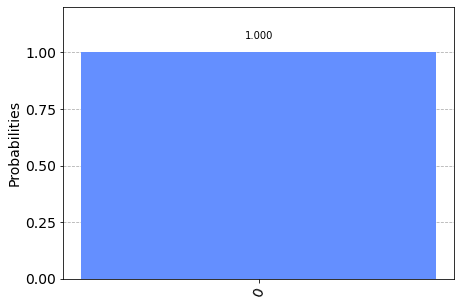

In [33]:
qobj_2a = assemble(qc_2a)
result_2a = QasmSimulator_backend.run(qobj_2a).result()
counts_2a = result_2a.get_counts()
plot_histogram(counts_2a)

**2. (b) Prepare $\vert 1 \rangle$ and measure in the computational basis.**

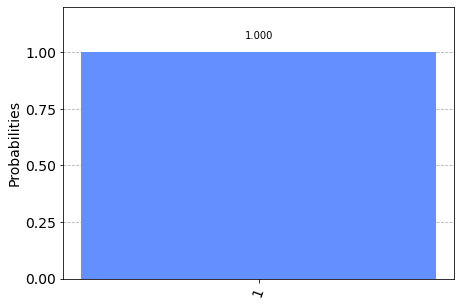

In [40]:
qc_2b = QuantumCircuit(1) 
qc_2b.x(0)
qc_2b.save_statevector() 
qobj_2b = assemble(qc_2b)
result_2b = QasmSimulator_backend.run(qobj_2b).result()
counts_2b = result_2b.get_counts()
plot_histogram(counts_2b)

**2. (c) Prepare $ \dfrac{1}{\sqrt{2}} ( \vert 0 \rangle + \vert 1 \rangle )$ and measure in the computational basis. Comment on the discrepancy from the ideal result. What is the number of shots needed to obtain an (average) accuracy of 1%?**

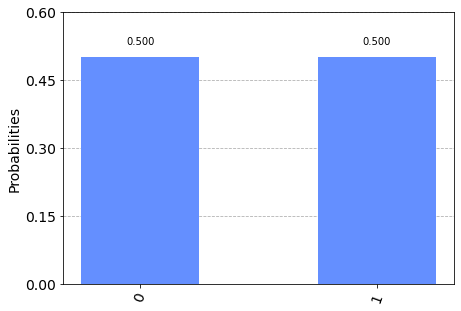

In [46]:
initial_state = [1/sqrt(2), 1/sqrt(2)]
qc_2c = QuantumCircuit(1)
qc_2c.initialize(initial_state, 0) # Initialize the 0th qubit in the state `initial_state`
qc_2c.save_statevector() # Save statevector
qobj_2c = assemble(qc_2c)
results = QasmSimulator_backend.run(qobj_2c, shots=1024).result().get_counts()
plot_histogram(results)   

From my results, I was able to reach accuracy of 1% using 1024 shots. The ideal results is 50% for each state, but becuase of randomness and error, we might need many shots to reach the desired accuracy

**2. (d) An end of a quantum a quantum computation always ends in measurement. Comment on any implications of your results in (c) on quantum algorithm implementations.**

In my opinion, I think the main takeaway is that: when you measure the system, you change the state of the system. The system will not longer be a superpositon of state. It will be 100% the state you measure it to be. So you don't want to measure the state before the end. However, there are workaround such as aer which allows us to peek the state during the calculation to make sure we're right

**2. (e) Design a circuit which will always give a measurement outcome of +1 for an input state defined by the Bloch vector $\dfrac{1}{\sqrt{2}}(0,1,1)$**

First, we need to prepare this state. Since in the cartesian coordinates y and z have equal magnitude and x = 0, the vector must be in the y-z plane, and it bisects the 90 degree angle form by the positive y and positive z axis. Therefore $\phi = 0.5 \pi, \theta = 0.25 \pi$

Pluggin this into the equation for the bloch sphere: $\psi = \cos(0.5 \theta) \vert 0 \rangle + e^{i \phi} \sin(0.5 \theta) \vert 1 \rangle $, we get the initial state $[\cos(\pi/8), i \sin{(\pi/8)}]$ 

Since this vector is in the y-z plane and the target state is also in the y-z plane, all we need to do is a rotation about the x-axis. This is an operation that can be accomplished with the Rx-gate.

The qiskit implementation is shown below:

In [128]:
import numpy as np

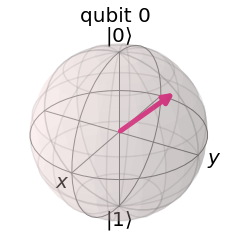

In [142]:
# This is the initial state with no gates
initial_state = [np.cos(pi/8), np.sin(pi/8)*1j]
qc_2e = QuantumCircuit(1)
qc_2e.initialize(initial_state, 0) 
qc_2e.save_statevector() 
qobj_2e = assemble(qc_2e)
state_2e = QasmSimulator_backend.run(qobj_2e).result().get_statevector() 
plot_bloch_multivector(state_2e)

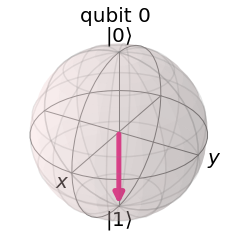

In [143]:
# Now we add rx gate to our circuit
initial_state = [np.cos(pi/8), np.sin(pi/8)*1j]
qc_2e = QuantumCircuit(1)
qc_2e.initialize(initial_state, 0) 
qc_2e.rx(5*pi/4,0)
qc_2e.save_statevector() 
qobj_2e = assemble(qc_2e)
state_2e = QasmSimulator_backend.run(qobj_2e).result().get_statevector() 
plot_bloch_multivector(state_2e)


In [144]:
qc_2e.draw()

┌──────────────────────────────┐┌──────────┐ ░ 
q: ┤ Initialize(0.92388,0.38268j) ├┤ Rx(5π/4) ├─░─
   └──────────────────────────────┘└──────────┘ ░

**3. (a) $ \vert 0 \rangle$**

In [81]:
qc_3a = QuantumCircuit(1)
qc_3a.save_statevector() 
qobj_3a = assemble(qc_3a)
state_3a = QasmSimulator_backend.run(qobj_3a).result().get_statevector() 
print(state_3a)   

Statevector([1.+0.j, 0.+0.j],
            dims=(2,))


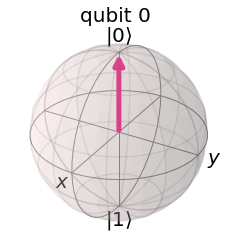

In [82]:
plot_bloch_multivector(state_3a)

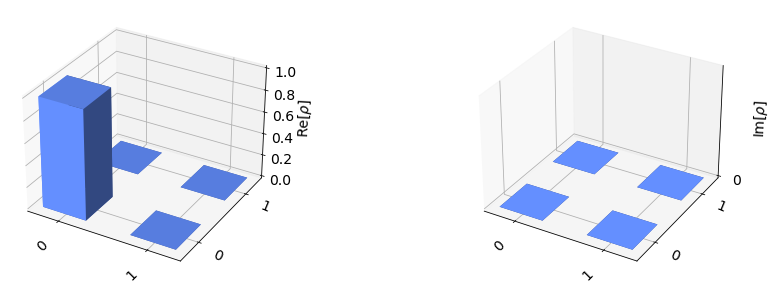

In [83]:
plot_state_city(state_3a)

**3. (b) $ \dfrac{1}{\sqrt{2}} (\vert 0 \rangle + \vert 1 \rangle )$**

In [63]:
initial_state = [1/sqrt(2), 1/sqrt(2)]
qc_3b = QuantumCircuit(1)
qc_3b.initialize(initial_state, 0) 
qc_3b.save_statevector() 
qobj_3b = assemble(qc_3b)
state_3b = QasmSimulator_backend.run(qobj_3b).result().get_statevector() 
print(state_3b)    

Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))


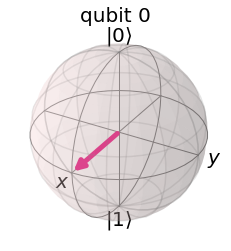

In [64]:
plot_bloch_multivector(state_3b)

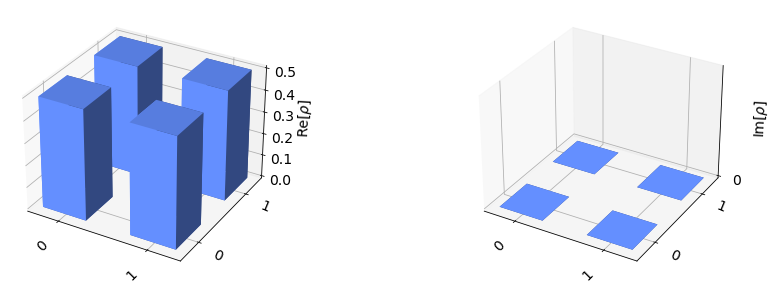

In [84]:
plot_state_city(state_3b)

**3. (c) $ \dfrac{1}{\sqrt{2}} (\vert 0 \rangle - i \vert 1 \rangle )$**

In [61]:
initial_state = [1/sqrt(2), -1j/sqrt(2)]
qc_3c = QuantumCircuit(1)
qc_3c.initialize(initial_state, 0) 
qc_3c.save_statevector() 
qobj_3c = assemble(qc_3c)
state_3c = QasmSimulator_backend.run(qobj_3c).result().get_statevector() 
print(state_3c)  

Statevector([ 0.70710678+0.j        , -0.        -0.70710678j],
            dims=(2,))


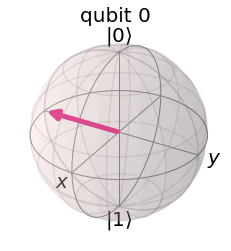

In [62]:
plot_bloch_multivector(state_3c)

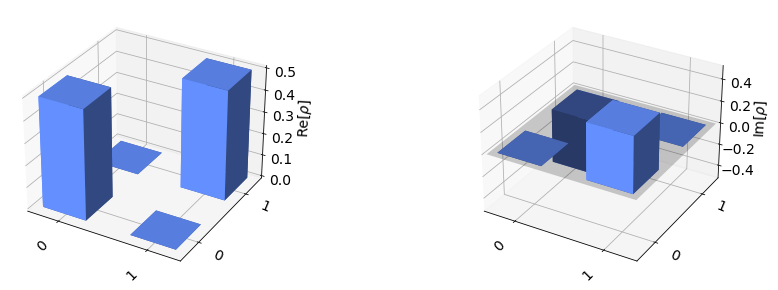

In [85]:
plot_state_city(state_3c)

** 4. (a) _Single qubit tomography_, ideal: Prepare the following states and plot both the density
matrix representation and Bloch sphere representation of the final state. Use
the QasmSimulator as the backend. After preparing your circuit (which should
consist of a single qubit), perform tomography using the StateTomography()[1].
(e.g. see tutorial.) Plot both the Bloch vector and also the “cityscape” of the
density matrix.**

**   4. (a) i. $\vert 0 \rangle$**

In [88]:

circuit_4a = QuantumCircuit(1)
qst_exp_4a = StateTomography(circuit_4a)
circuit_4a_data =  qst_exp_4a.run(ionq_simulator_backend, shots=1000).block_for_results()

meas_level is not a known attribute of class <class 'azure.quantum._client.models._models_py3.JobDetails'> and will be ignored
meas_level is not a known attribute of class <class 'azure.quantum._client.models._models_py3.JobDetails'> and will be ignored
meas_level is not a known attribute of class <class 'azure.quantum._client.models._models_py3.JobDetails'> and will be ignored


............

In [89]:
state_result_4a = circuit_4a_data.analysis_results("state")
print(state_result_4a.value)

DensityMatrix([[9.99686295e-01+0.j        , 1.69893340e-02-0.00499686j],
               [1.69893340e-02+0.00499686j, 3.13704521e-04+0.j        ]],
              dims=(2,))


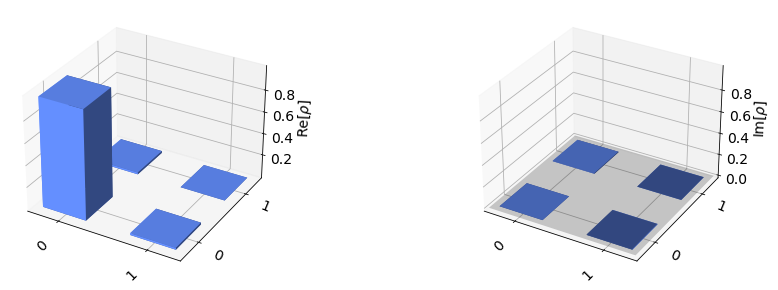

In [90]:
plot_state_city(state_result_4a.value)

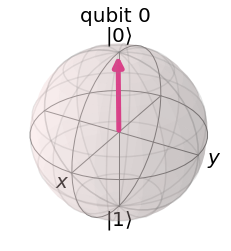

In [92]:
plot_bloch_multivector(state_result_4a.value)

**   4. (a) ii. $\vert 1 \rangle$**

In [145]:

circuit_4a_2 = QuantumCircuit(1)
circuit_4a_2.x(0)
qst_exp_4a_2 = StateTomography(circuit_4a_2)
circuit_4a_2_data =  qst_exp_4a_2.run(ionq_simulator_backend, shots=1000).block_for_results()
state_result_4a_2 = circuit_4a_2_data.analysis_results("state")
print(state_result_4a_2.value)


meas_level is not a known attribute of class <class 'azure.quantum._client.models._models_py3.JobDetails'> and will be ignored
meas_level is not a known attribute of class <class 'azure.quantum._client.models._models_py3.JobDetails'> and will be ignored
meas_level is not a known attribute of class <class 'azure.quantum._client.models._models_py3.JobDetails'> and will be ignored


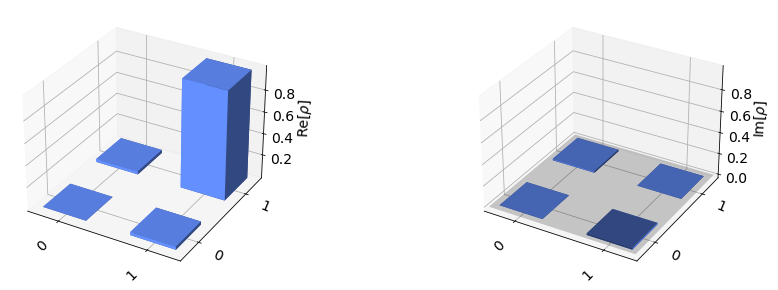

In [146]:
plot_state_city(state_result_4a_2.value)

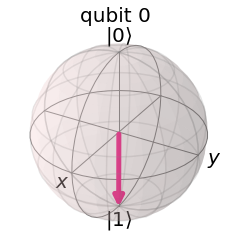

In [147]:
plot_bloch_multivector(state_result_4a_2.value)

**   4. (a) iii. $ \dfrac{1}{\sqrt{2} }( \vert 0 \rangle + \vert 1 \rangle )$**

In [100]:
initial_state = [1/sqrt(2), 1/sqrt(2)]
circuit_4a_3 = QuantumCircuit(1)
circuit_4a_3.initialize(initial_state, 0) 
qst_exp_4a_3 = StateTomography(circuit_4a_3)
circuit_4a_3_data =  qst_exp_4a_3.run(QasmSimulator_backend, shots=1000).block_for_results()
state_result_4a_3 = circuit_4a_3_data.analysis_results("state")

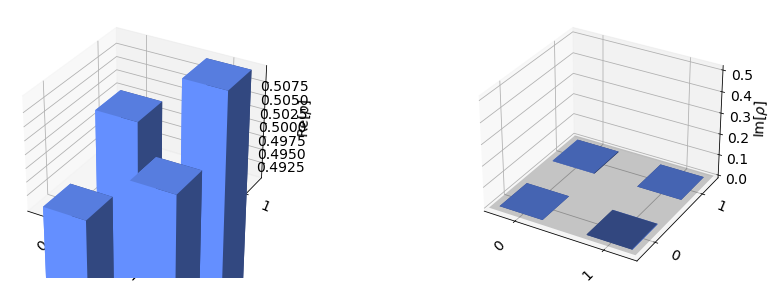

In [101]:
plot_state_city(state_result_4a_3.value)

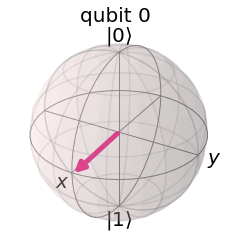

In [102]:
plot_bloch_multivector(state_result_4a_3.value)

**   4. (a) iii. $ \dfrac{1}{\sqrt{2} }( \vert 0 \rangle - i \vert 1 \rangle )$**

In [104]:
initial_state = [1/sqrt(2), -1j/sqrt(2)]
circuit_4a_4 = QuantumCircuit(1)
circuit_4a_4.initialize(initial_state, 0) 
qst_exp_4a_4 = StateTomography(circuit_4a_4)
circuit_4a_4_data =  qst_exp_4a_4.run(QasmSimulator_backend, shots=1000).block_for_results()
state_result_4a_4 = circuit_4a_4_data.analysis_results("state")

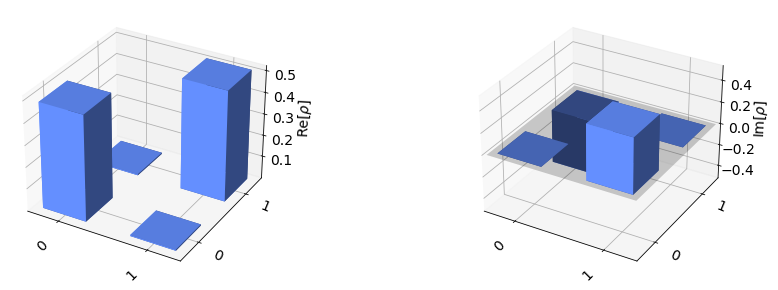

In [105]:
plot_state_city(state_result_4a_4.value)

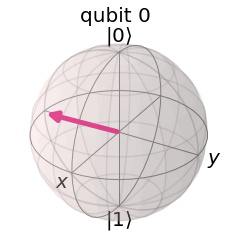

In [106]:
plot_bloch_multivector(state_result_4a_4.value)

**4. (b) i. Estimate the number of shots you need to detect SPAM errors with S/N of 10 assuming the 0.7% SPAM error rate.**

To detemine this, we can assume a normal (gaussian) distribution and use a 99.93% confidence level to perfom the z-test. I would estimate we need ~20000 shots to get a S/N of 10

**4. (b) ii. For state | 0 ⟩ , run the qiskit tomography code with the number of steps from (i) using the ionq.simulator backend to check your results are reasonable. **

ionq_simulator wont allow too many shots. I will only use 1000 shots.

In [108]:
circuit_4b = QuantumCircuit(1)
qst_exp = StateTomography(circuit_4b)
#circuit_4b_data =  qst_exp.run(ionq_simulator_backend, seed_simulation=100).block_for_results()
circuit_4b_data =  qst_exp.run(ionq_simulator_backend, shots=1000).block_for_results()

meas_level is not a known attribute of class <class 'azure.quantum._client.models._models_py3.JobDetails'> and will be ignored
meas_level is not a known attribute of class <class 'azure.quantum._client.models._models_py3.JobDetails'> and will be ignored
meas_level is not a known attribute of class <class 'azure.quantum._client.models._models_py3.JobDetails'> and will be ignored


In [112]:
state_result_4b = circuit_4b_data.analysis_results("state")
print(state_result_4b.value)

DensityMatrix([[ 9.99627417e-01+0.j        , -6.99478384e-03-0.01798659j],
               [-6.99478384e-03+0.01798659j,  3.72583131e-04+0.j        ]],
              dims=(2,))


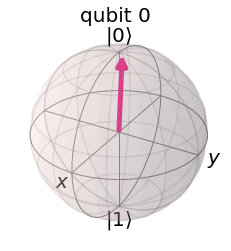

In [115]:
plot_bloch_multivector(state_result_4b.value)

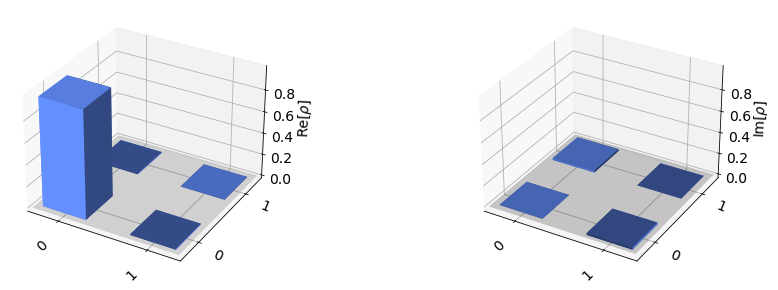

In [111]:
plot_state_city(state_result_4b.value)

In [116]:
fid_result_4b = circuit_4b_data.analysis_results("state_fidelity")
print("State Fidelity = {:.5f}".format(fid_result_4b.value))

State Fidelity = 0.99963


**4. (b) iii. Run the resource estimation step to check that resources are reasonable. Share your resource estimation on the discussion board for approval to move to the next step. **

In [117]:

circuit_4c = QuantumCircuit(1)
qstexp_4c = StateTomography(circuit_4c)
circ = qiskit.transpile(qstexp_4c.circuits(), ionq_qpu_backend)
for c in circ:
    cost = ionq_qpu_backend.estimate_cost(c, shots=20000)
    print(cost)


{'additional_properties': {}, 'currency_code': 'USD', 'events': [<azure.quantum._client.models._models_py3.UsageEvent object at 0x7fa430930f50>, <azure.quantum._client.models._models_py3.UsageEvent object at 0x7fa3f559d450>], 'estimated_total': 1.0}
{'additional_properties': {}, 'currency_code': 'USD', 'events': [<azure.quantum._client.models._models_py3.UsageEvent object at 0x7fa3b2dd5050>, <azure.quantum._client.models._models_py3.UsageEvent object at 0x7fa3f557ff10>], 'estimated_total': 1.0}
{'additional_properties': {}, 'currency_code': 'USD', 'events': [<azure.quantum._client.models._models_py3.UsageEvent object at 0x7fa3b2d11290>, <azure.quantum._client.models._models_py3.UsageEvent object at 0x7fa3cc22f210>], 'estimated_total': 1.2}


**4. (b) iv. Run your code in (ii) on the ionq-qpu for the input states $\vert 0 \rangle$ and $\vert 1 \rangle$. **

For state $\vert 0 \rangle$:


In [17]:
circuit_4b_0state = QuantumCircuit(1)
qst_exp_4b_0state = StateTomography(circuit_4b_0state)
circuit_4b_0state_data =  qst_exp_4b_0state.run(ionq_qpu_backend, shots=1000).block_for_results()
print(circuit_4b_0state_data.job_ids)

meas_level is not a known attribute of class <class 'azure.quantum._client.models._models_py3.JobDetails'> and will be ignored
meas_level is not a known attribute of class <class 'azure.quantum._client.models._models_py3.JobDetails'> and will be ignored
meas_level is not a known attribute of class <class 'azure.quantum._client.models._models_py3.JobDetails'> and will be ignored


.......................................................['cef43e30-b48f-11ec-a0ad-00155d5259eb', 'cf3dfab6-b48f-11ec-a0ad-00155d5259eb', 'cf6d052c-b48f-11ec-a0ad-00155d5259eb']


In [119]:
state_result_0state = circuit_4b_0state_data.analysis_results("state")
print(state_result_0state.value)

DensityMatrix([[ 9.99459876e-01+0.j       , -2.09773148e-02-0.0099892j],
               [-2.09773148e-02+0.0099892j,  5.40123537e-04+0.j       ]],
              dims=(2,))


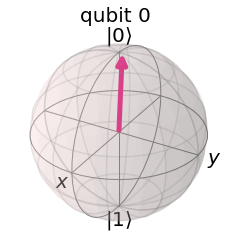

In [120]:
plot_bloch_multivector(state_result_0state.value)

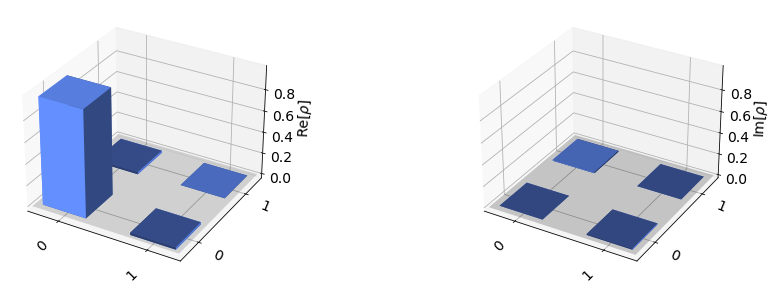

In [121]:
plot_state_city(state_result_0state.value)

In [127]:
fid_result_0state = circuit_4b_0state_data.analysis_results("state_fidelity")
print("State Fidelity = {:.5f}".format(fid_result_0state.value))

State Fidelity = 0.99946


For state $\vert 1 \rangle$:

In [19]:
circuit_4b_1state = QuantumCircuit(1)
circuit_4b_1state.x(0)
qst_exp_4b_1state = StateTomography(circuit_4b_1state)
circuit_4b_1state_data =  qst_exp_4b_1state.run(ionq_qpu_backend, shots=1000).block_for_results()
print(circuit_4b_1state_data.job_ids)

meas_level is not a known attribute of class <class 'azure.quantum._client.models._models_py3.JobDetails'> and will be ignored
meas_level is not a known attribute of class <class 'azure.quantum._client.models._models_py3.JobDetails'> and will be ignored
meas_level is not a known attribute of class <class 'azure.quantum._client.models._models_py3.JobDetails'> and will be ignored


In [22]:
circuit_4b_1state_data.job_ids


['0b1587c2-b493-11ec-a0ad-00155d5259eb',
 '0b704856-b493-11ec-a0ad-00155d5259eb',
 '0b940af2-b493-11ec-a0ad-00155d5259eb']

In [123]:
state_result_1state = circuit_4b_1state_data.analysis_results("state")
print(state_result_1state.value)

DensityMatrix([[0.007+0.j   , 0.03 -0.018j],
               [0.03 +0.018j, 0.993+0.j   ]],
              dims=(2,))


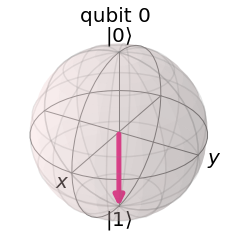

In [124]:
plot_bloch_multivector(state_result_1state.value)

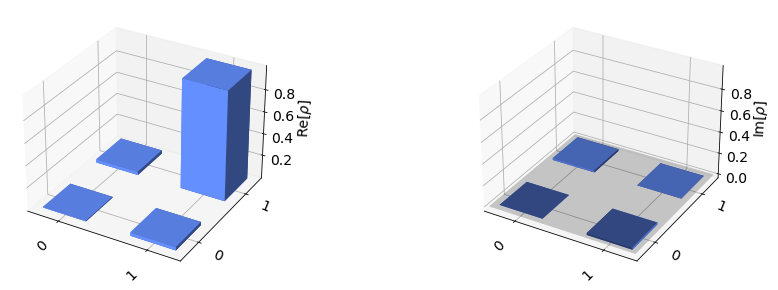

In [125]:
plot_state_city(state_result_1state.value)

In [126]:
fid_result_1state = circuit_4b_1state_data.analysis_results("state_fidelity")
print("State Fidelity = {:.5f}".format(fid_result_1state.value))

State Fidelity = 0.99300


**4. (b) v. Discuss your results including any deviations in both the length and angle of the Bloch vector. **

It's obviously to see that the length of the Bloch vector gets smaller. This is particularly true for $\vert 1 \rangle$ state, which has a lower fidelity. Also, we are able to see small angles being introduced to the system such that the vectors are no longer sitting perfectly on the z-axis. This means that there are errors and noises associated with our job on the quantum computer, which shouldb be expected.